In [1]:
from Environment import Ecosystem
import pygame
import matplotlib.pyplot as plt

pygame-ce 2.5.1 (SDL 2.30.6, Python 3.11.9)


In [2]:
default_params = {
  "mapsize": 1024,
  "min_depth": 10,
  "max_depth": 20,
  "starting_population": 10,
  "food_value": 200,
  "max_timesteps": 200000,
  "movement_cost_factor": 0.005,
  "food_per_agent": 4,
  "egg_incubation_time": 100,
  "mutation_factor": 2
}

In [3]:
env = Ecosystem("human", params=default_params, debug=False)
env.reset()
try:
    while not env.finished:
        env.stepper()
except KeyboardInterrupt:
    env.close()

[[10 10 10 ... 11 11 11]
 [10 10 10 ... 11 11 11]
 [10 10 10 ... 11 11 11]
 ...
 [12 12 12 ... 20 20 20]
 [12 12 12 ... 20 20 20]
 [12 12 12 ... 20 20 20]]
<Surface(1024x1024x32)>
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Agent death
Closing environment Ecosystem at 6518 timestep.


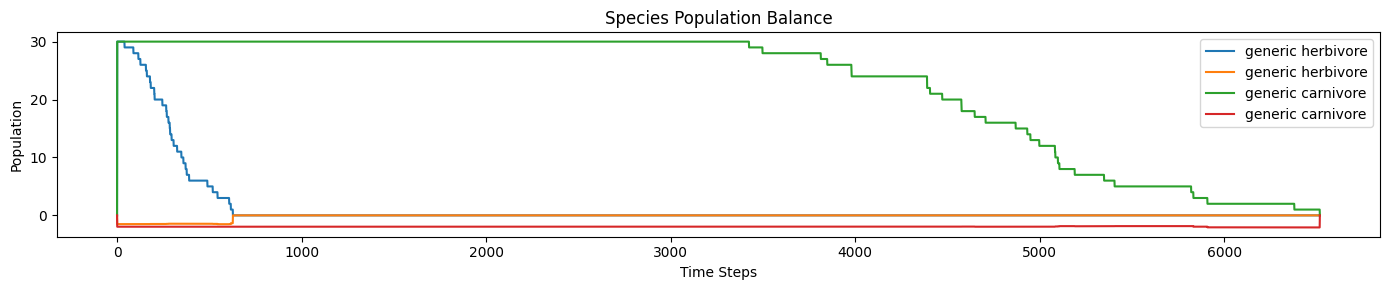

In [4]:
fig, ax = plt.subplots(figsize=(14, 3))
for species, history in env.full_population_history.items():
    ax.plot(history, label=env.species[species]["name"])

ax.set_title("Species Population Balance")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Population")
ax.legend()
plt.tight_layout()

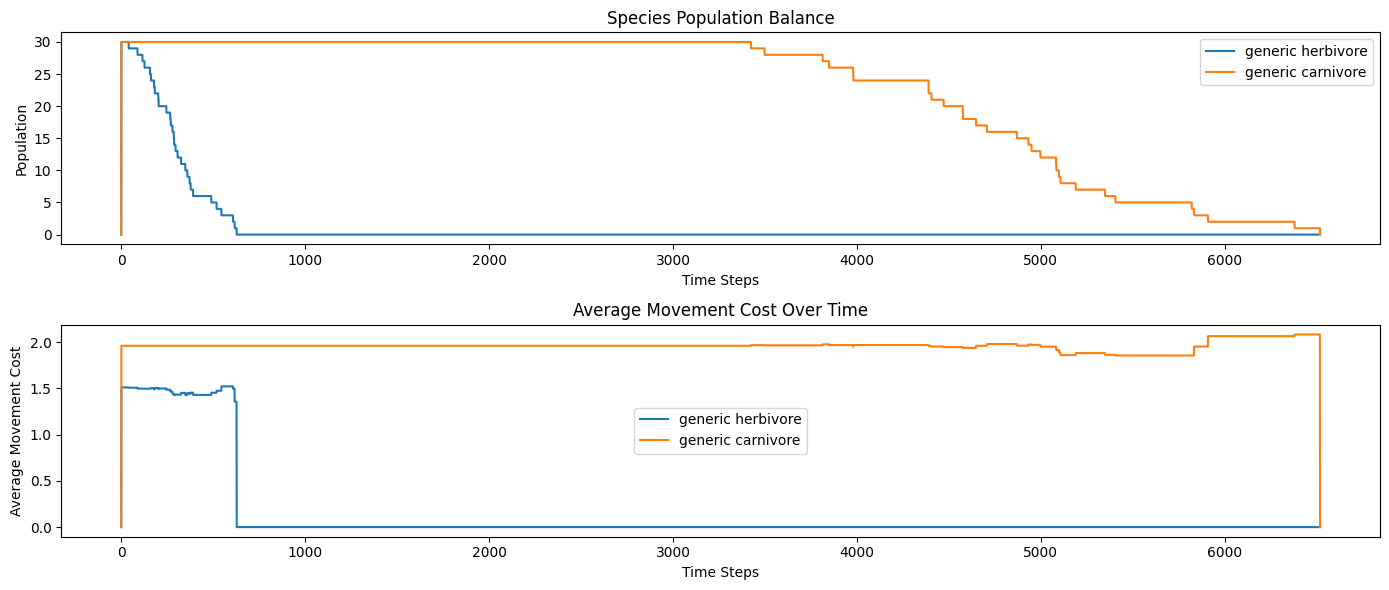

In [5]:
import matplotlib.pyplot as plt

# Assuming env.full_population_history is a dictionary where:
# - keys are species names
# - values are lists of tuples (population, average_movement_cost)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 6))

# Plot population size
for species, history in env.full_population_history.items():
    population_history = [pop for pop, _ in history]  # Extract population values
    ax1.plot(population_history, label=env.species[species]["name"])

ax1.set_title("Species Population Balance")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Population")
ax1.legend()

# Plot average movement cost
for species, history in env.full_population_history.items():
    movement_cost_history = [-cost for _, cost in history]  # Extract movement cost values
    ax2.plot(movement_cost_history, label=env.species[species]["name"])

ax2.set_title("Average Movement Cost Over Time")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Average Movement Cost")
ax2.legend()

plt.tight_layout()
plt.show()

C:\Users\creep\AppData\Local\Temp\ipykernel_27248\753611675.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  total_food += agent.food / agent.stomach_size
C:\Users\creep\AppData\Local\Temp\ipykernel_27248\753611675.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_food.show()
C:\Users\creep\AppData\Local\Temp\ipykernel_27248\753611675.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_population.show()
C:\Users\creep\AppData\Local\Temp\ipykernel_27248\753611675.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cost.show()


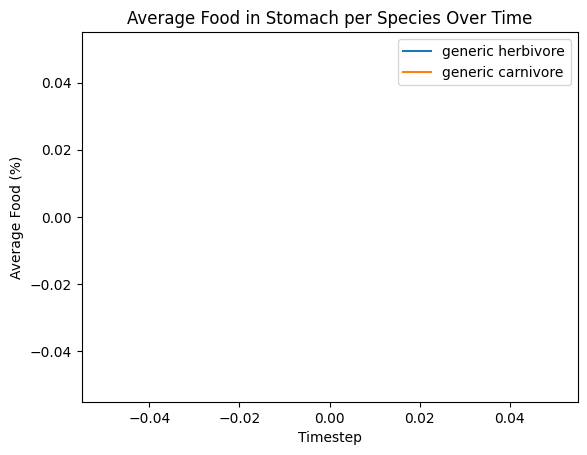

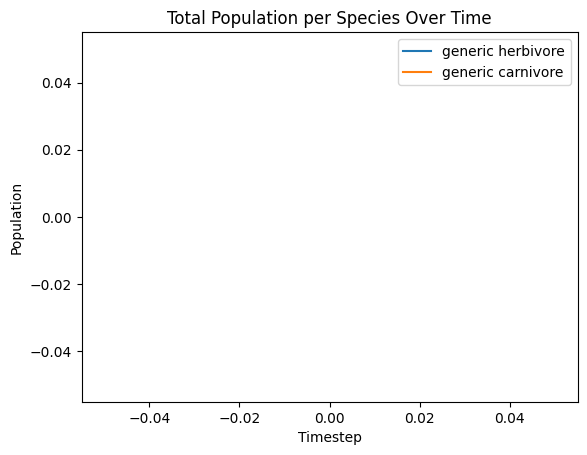

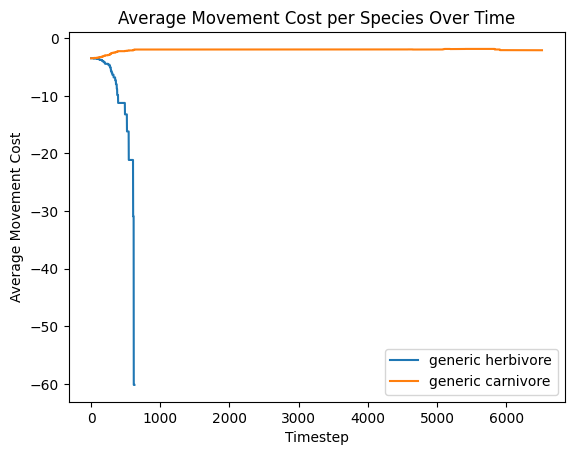

In [6]:
import matplotlib.pyplot as plt

def analyze_environment(env, parameter):
    """
    Analyzes the environment and creates a line graph based on the specified parameter.

    Args:
        env: The environment object.
        parameter: The parameter to analyze ("average_food", "population_total", "movement_cost").

    Returns:
        A matplotlib figure object.
    """

    if parameter not in ["average_food", "population_total", "movement_cost"]:
        raise ValueError("Invalid parameter. Choose from: 'average_food', 'population_total', 'movement_cost'")

    # Initialize data structures
    timesteps = range(len(env.agent_history))
    species_data = {species: [] for species in env.species.keys()}

    # Calculate average data for each species at each timestep
    for timestep, agents in enumerate(env.agent_history):
        species_counts = {s: 0 for s in env.species.keys()}  # Track species counts per timestep
        total_food = 0
        total_movement_cost = 0
        for name, agent in agents.items():
            species = agent.stats["species"]
            species_counts[species] += 1
            if parameter == "average_food":
                total_food += agent.food / agent.stomach_size
            elif parameter == "movement_cost":
                total_movement_cost += agent.movement_cost

        # Calculate average values (if there are agents of that species at the timestep)
        for species, count in species_counts.items():
            if count > 0:
                if parameter == "average_food":
                    species_data[species].append(total_food / count * 100)
                elif parameter == "movement_cost":
                    species_data[species].append(total_movement_cost / count)
            else:
                species_data[species].append(float('nan'))  # Append NaN for missing data

    # Create the plot
    fig, ax = plt.subplots()
    for species, data in species_data.items():
        ax.plot(data, label=env.species[species]["name"])

    # Set plot labels and title
    if parameter == "average_food":
        ax.set_ylabel("Average Food (%)")
        ax.set_title("Average Food in Stomach per Species Over Time")
    elif parameter == "population_total":
        ax.set_ylabel("Population")
        ax.set_title("Total Population per Species Over Time")
    elif parameter == "movement_cost":
        ax.set_ylabel("Average Movement Cost")
        ax.set_title("Average Movement Cost per Species Over Time")

    ax.set_xlabel("Timestep")
    ax.legend()
    return fig

# Example usage:
fig_food = analyze_environment(env, "average_food")
fig_food.show() 

fig_population = analyze_environment(env, "population_total")
fig_population.show()

fig_cost = analyze_environment(env, "movement_cost")
fig_cost.show()

In [7]:
env = Ecosystem("human", params=default_params, debug=False)
env.reset()
for i in range(10000000):
  env.stepper()
  if len(env.agentNames) == 0:
    break
env.close()

[[10 10 10 ... 11 11 11]
 [10 10 10 ... 11 11 11]
 [10 10 10 ... 11 11 11]
 ...
 [12 12 12 ... 20 20 20]
 [12 12 12 ... 20 20 20]
 [12 12 12 ... 20 20 20]]
<Surface(1024x1024x32)>
Agent death
Agent death
Agent death
Closing environment Ecosystem at 79 timestep.


error: video system not initialized

In [8]:
env.close()

Closing environment Ecosystem at 6152 timestep.
